
![screenshot1](https://github.com/hyeonsangjeon/Hyperparameters-Optimization/blob/master/pic/Turbo-Snail-Turbo-Funny-Black-Silver.jpg?raw=true)
- 하이퍼 파라미터 조정은 모든 기계 학습 프로젝트의 필수 부분이며 가장 시간이 많이 걸리는 작업 중 하나입니다. 
- 가장 단순한 모델의 경우에도 하루, 몇 주 또는 그 이상 최적화 할 수있는 신경망을 언급하지 않고 최적의 매개 변수를 찾는 데 몇 시간이 걸릴 수 있습니다. 
- 이 튜토리얼에서는 Grid Search , Random Search, HyperBand, Bayesian optimization, Tree-structured Parzen Estimator(TPE)에 대해 소개합니다. 
- 하이퍼 파라미터 조정은 함수 최적화 작업에 지나지 않습니다. 그리고 분명히 Grid 또는 Random Search가 유일하고 최상의 알고리즘은 아니지만 효율적인 속도와 결과 측면에서 꾸준히 사용됩니다. 
- 이론적 관점에서 어떻게 작동하는지 설명하고 Hyperopt 라이브러리를 사용하여 실제로 사용하는 방법을 보여줄 것입니다.
- 이 튜토리얼을 마치면 모델링 프로세스의 속도를 쉽게 높이는 방법을 알게됩니다. 
- 튜토리얼의 유일한 목표는 매우 단순화 된 예제에서 Hyperparameter optimization을 사용하는 방법을 시연하고 설명하는 것입니다.

In [1]:
#!pip install pip install git+https://github.com/darenr/scikit-optimize

## Preparation step
- 표준 라이브러리를 가져 옵니다


In [22]:
#!pip install lightgbm
import numpy as np
import pandas as pd

from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

#### sklearn.datasets의 당뇨병 데이터 세트에 대한 다양한 알고리즘을 시연하고 비교합니다. 로드합시다.

여기에서 데이터 세트에 대한 설명을 찾을 수 있습니다. [https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html] 
add: 일부 환자 및 대상 측정 항목에 대한 정보가 포함 된 데이터 세트입니다. "기준선 1 년 후 질병 진행의 정량적 측정". 
이 예제의 목적을 위해 데이터를 이해할 필요도 없습니다. 회귀 문제를 해결하고 있으며 하이퍼 파라미터를 조정하려고한다는 점을 명심하십시오.

In [23]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
n = diabetes.data.shape[0]

data = diabetes.data
targets = diabetes.target

- 데이터 세트는 매우 작습니다. 
- 이를 사용하여 기본 개념을 쉽게 보여줄 수 있기 때문에 선택했습니다.( 모든 것이 계산 될 때 몇 시간을 기다릴 필요가 없습니다.) 
- 데이터 세트를 학습 및 테스트 부분으로 나눌 것입니다. train 부분은 2 개로 분할되며, 매개 변수를 최적화하는 데 따라 교차 검증 MSE를 최종 측정 항목으로 사용할 것입니다. 

add :이 간단한 예제는 실제 모델링을 위한 방법이 아닙니다. 빠른 데모 소개에만 사용하는 작은 데이터 세트와 2 개의 fold로 인해 불안정 할 수 있습니다. 결과는 random_state에 따라 크게 변경됩니다.

iteration은 50으로 고정합니다.


In [24]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

random_state=42
n_iter=50

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, 
                                                                      test_size=0.20, shuffle=True,
                                                                      random_state=random_state)
num_folds=2
kf = KFold(n_splits=num_folds, random_state=random_state)

In [25]:
print('train_data : ',train_data.shape)
print('test_data : ',test_data.shape)

print('train_targets : ',train_targets.shape)
print('test_targets : ',test_targets.shape)

train_data :  (353, 10)
test_data :  (89, 10)
train_targets :  (353,)
test_targets :  (89,)


### 모델생성

LGBMRegressor를 사용하여 문제를 해결해봅니다. Gradient Boosting에는 최적화 할 수있는 많은 하이퍼 파라미터가 있으므로 데모에 적합한 선택입니다.

In [26]:
model = LGBMRegressor(random_state=random_state)


기본 매개 변수를 사용하여 기준 모델을 학습 해 보겠습니다.

- 즉시 출력된 모델의 결과는 3532입니다. 

In [27]:
%%time
score = -cross_val_score(model, train_data, train_targets, cv=kf, scoring="neg_mean_squared_error", n_jobs=-1).mean()
print(score)

3532.0822189641976
CPU times: user 36.9 ms, sys: 57 ms, total: 94 ms
Wall time: 750 ms


#### 실험에 사용한 Scikit-Learn의 파라미터는 아래와 같습니다. 
- base_estimator: 기본 모형
- n_estimators: 모형 갯수. 디폴트 10
- bootstrap: 데이터의 중복 사용 여부. 디폴트 True
- max_samples: 데이터 샘플 중 선택할 샘플의 수 혹은 비율. 디폴트 1.0
- bootstrap_features: 특징 차원의 중복 사용 여부. 디폴트 False
- max_features: 다차원 독립 변수 중 선택할 차원의 수 혹은 비율 1.0


#### 최적화 접근 방식을 사용하여 데모 목적으로 3 개의 매개 변수 만 조정하는 모델을 최적화 하는 예제입니다. 
- n_estimators: from 100 to 2000
- max_depth: from 2 to 20
- learning_rate: from 10e-5 to 1


#### Computing power는 일반적인 로컬 미니서버와 클라우드컴퓨팅 환경을 사용했습니다. 
- 로컬미니서버 : AMD 2700x (1 CPU - 8Core)
- 클라우드서버 : Accuinsight+ modeler (18 CPU- 162core) [Intel(R) Xeon(R) 2.00GHZ]

# 1. GridSearch


하이퍼 파라미터 최적화를 수행하는 전통적인 방법은 그리드 검색 또는 매개 변수 스윕으로, 학습 알고리즘의 하이퍼 파라미터 공간에서 수동으로 지정된 하위 집합을 통해 전체적으로 검색하는 것입니다. 

- 가장 먼저 시도해 볼 수있는 가장 간단한 방법은 sklearn.model_selection에 포함 된 GridSearchCV입니다.이 접근 방식은 사용 가능한 모든 매개 변수의 조합을 1 x 1로 시도하고 최상의 교차 검증 결과를 가진 것을 선택합니다.


이 접근 방식에는 몇 가지 단점이 있습니다.

1. 매우 느립니다. 모든 매개 변수의 모든 조합을 시도하고 많은 시간이 걸립니다. 변량 할 추가 매개 변수는 완료해야하는 반복 횟수를 곱합니다. 가능한 값이 10 개인 새 매개 변수를 매개 변수 그리드에 추가한다고 가정 해보십시오.이 매개 변수는 무의미한 것으로 판명 될 수 있지만 계산 시간은 10 배 증가합니다. 
2. 이산 값으로 만 작동 할 수 있습니다. 전역 최적 값이 n_estimators = 550이지만 100 단계에서 100에서 1000까지 GridSearchCV를 수행하는 경우 최적 점에 도달하지 못할 것입니다. 
3. 적절한 시간에 검색을 완료하려면 approximate localization of the optimum를 알고 / 추측해야합니다.

이러한 단점 중 일부를 극복 할 수 있습니다. 매개 변수별로 그리드 검색 매개 변수를 수행하거나 큰 단계가있는 넓은 그리드에서 시작하여 여러 번 사용하고 반복에서 경계를 좁히고 단계 크기를 줄일 수 있습니다. 하지만, 여전히 매우 계산 집약적이고 길 것입니다.

- 우리의 경우 그리드 검색을 수행하는 데 걸리는 시간을 추정 해 보겠습니다. 
> - 그리드가 'n_estimators'(100 ~ 2000)의 가능한 값 20 개, 
> - 'max_depth'의 19 개 값 (2 ~ 20), 
> - 'learning_rate'(10e-4 ~ 0.1)의 5 개 값으로 구성되기를 원한다고 가정 해 보겠습니다.
- 즉, cross_val_score 20 * 19 * 5 = 1900 번 계산해야합니다. 1 번 계산에 0.5 ~ 1.0 초가 걸리면 그리드 검색은 15 ~ 30 분 동안 지속됩니다. ~ 400 데이터 포인트가있는 데이터 세트에는 너무 많습니다.
- 실험 시간은 오래 걸리지 말아야하므로, 이 방법을 사용하여 분석 할 구간을 좁혀 야합니다. 5 * 8 * 3 = 120 조합 만 남겼습니다.      
> - Accuinsight+ modeler (18 CPU- 162core) Wall time: 5.5 s
> - AMD 2700x (1 CPU - 8Core) Wall time: 18.3 s 

In [17]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid={'max_depth':  np.linspace(5,12,8,dtype = int),
            'n_estimators': np.linspace(800,1200,5, dtype = int),
            'learning_rate': np.logspace(-3, -1, 3),            
            'random_state': [random_state]}

gs=GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=kf, verbose=False)

gs.fit(train_data, train_targets)
gs_test_score=mean_squared_error(test_targets, gs.predict(test_data))


print('===========================')
print("Best MSE = {:.3f} , when params {}".format(-gs.best_score_, gs.best_params_))
print('===========================')

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Best MSE = 3319.975 , when params {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 800, 'random_state': 42}
CPU times: user 4.16 s, sys: 46.4 ms, total: 4.21 s
Wall time: 5.26 s


결과를 개선했지만, 그것에 많은 시간을 보냈습니다. 매개 변수가 반복에서 반복으로 어떻게 변경되었는지 살펴 보겠습니다.

- 아래 그림에서, (MSE가 낮을때 각 변수관계 참조)
> - 예를 들어 max_depth는 점수에 크게 영향을주지 않는 가장 덜 중요한 매개 변수임을 알 수 있습니다. 그러나 우리는 max_depth의 8 가지 다른 값을 검색하고 다른 매개 변수에 대한 고정 값 검색을 사용합니다. 시간과 자원의 낭비입니다. 

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

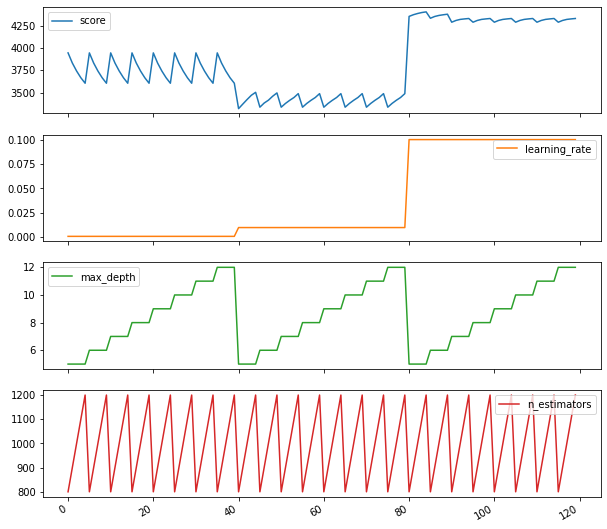

In [18]:
gs_results_df=pd.DataFrame(np.transpose([-gs.cv_results_['mean_test_score'],
                                         gs.cv_results_['param_learning_rate'].data,
                                         gs.cv_results_['param_max_depth'].data,
                                         gs.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
gs_results_df.plot(subplots=True,figsize=(10, 10))

# 2. Random Search

### Research Paper [Random Search](https://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf)

- Random Search는 그리드 검색보다 평균적으로 더 효과적입니다.


<img src="https://raw.githubusercontent.com/nslatysheva/data_science_blogging/master/expanding_ML_toolkit/expanding_toolkit.jpg" style="height:500px;width:50%;"/>

#### 주요 장점 : 
1. 의미없는 매개 변수에 시간을 소비하지 앉음. 모든 단계에서 무작위 검색은 모든 매개 변수를 변경합니다. 
2. 평균적으로 그리드 검색보다 훨씬 빠르게 ~ 최적의 매개 변수를 찾습니다. 
3. 연속 매개 변수를 최적화 할 때 그리드에 의해 제한되지 않습니다.

#### 단점: 
1. 그리드에서 글로벌 최적 매개 변수를 찾지 못할 수 있습니다. 
2. 모든 단계는 독립적입니다. 모든 특정 단계에서 지금까지 수집 된 결과에 대한 정보를 사용하지 않습니다. 

예제는, sklearn.model_selection에서 RandomizedSearchCV를 사용합니다.
매우 넓은 매개 변수 공간으로 시작하여 50 개의 무작위 단계 만 만들 것입니다.

수행속도:
> - Accuinsight+ modeler (18 CPU- 162core) Wall time: 2.51 s
> - AMD 2700x (1 CPU - 8Core) Wall time: 3.08 s 

In [28]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid_rand={'learning_rate': np.logspace(-5, 0, 100),
                 'max_depth':  randint(2,20),
                 'n_estimators': randint(100,2000),
                 'random_state': [random_state]}

rs=RandomizedSearchCV(model, param_grid_rand, n_iter = n_iter, scoring='neg_mean_squared_error',
                n_jobs=-1, cv=kf, verbose=False, random_state=random_state)

rs.fit(train_data, train_targets)

rs_test_score=mean_squared_error(test_targets, rs.predict(test_data))

print('===========================')
print("Best MSE = {:.3f} , when params {}".format(-rs.best_score_, rs.best_params_))
print('===========================')

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Best MSE = 3200.402 , when params {'learning_rate': 0.0047508101621027985, 'max_depth': 19, 'n_estimators': 829, 'random_state': 42}
CPU times: user 5.78 s, sys: 42.2 ms, total: 5.82 s
Wall time: 3.27 s


결과는 GridSearchCV보다 낫습니다. 더 적은 시간을 소비하고 더 완전한 검색을했습니다. 시각화를 살펴 보겠습니다.
- random search의 모든 단계는 완전히 무작위입니다. 쓸모없는 매개 변수에 시간을 소비하지 않는 데 도움이되지만 여전히 첫 번째 단계에서 수집 된 정보를 사용하여 후자의 결과를 개선하지 않습니다.

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

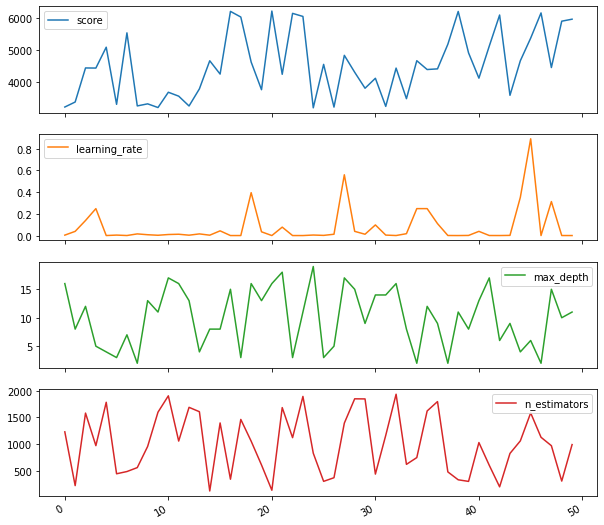

In [29]:
rs_results_df=pd.DataFrame(np.transpose([-rs.cv_results_['mean_test_score'],
                                         rs.cv_results_['param_learning_rate'].data,
                                         rs.cv_results_['param_max_depth'].data,
                                         rs.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

#https://www.kaggle.com/ishivinal/hyperparamters-optimization-gs-rs-boa-tpe-hb-ga
## 3. HyperBand

### Research Paper [HyperBand](https://arxiv.org/pdf/1603.06560.pdf)
Abstract 발췌:
머신 러닝 알고리즘의 성능은 좋은 하이퍼 파라미터 집합을 식별하는 데 매우 중요합니다. 최근 접근 방식은 베이지안 최적화를 사용하여 구성을 적응 적으로 선택하지만 적응 형 리소스 할당 및 조기 중지를 통해 임의 검색 속도를 높이는 데 중점을 둡니다. 반복, 데이터 샘플 또는 기능과 같은 사전 정의 된 리소스가 무작위로 샘플링 된 구성에 할당되는 순수 탐색 비 확률 적 무한 무장 밴디트 문제로 하이퍼 파라미터 최적화를 공식화합니다. 이 프레임 워크에 대해 새로운 알고리즘 인 Hyperband를 도입하고 이론적 속성을 분석하여 몇 가지 바람직한 보장을 제공합니다. 또한, 하이퍼 파라미터 최적화 문제 모음에 대해 Hyperband를 인기있는 베이지안 최적화 방법과 비교합니다. Hyperband는 다양한 딥 러닝 및 커널 기반 학습 문제에 대해 경쟁 업체보다 훨씬 빠른 속도를 제공 할 수 있습니다. © 2018 Lisha Li, Kevin Jamieson, Giulia DeSalvo, Afshin Rostamizadeh 및 Ameet Talwalkar.


<img src="https://github.com/hyeonsangjeon/Hyperparameters-Optimization/blob/master/pic/Hyperband.png?raw=true" />

- Hyperband Search는 최적화 검색 속도에 중점을 둡니다. 
- n개의 하이퍼파라미터 조합을 랜덤 샘플링.
- 전체 resource를 n개로 분할하고, 하이퍼 파라미터 조합에 각각 할당하여 학습
- 각 학습 프로세스는 일정 비율 이상의 상위 조합을 남기고 버림. 


수행속도:
> - Accuinsight+ modeler (18 CPU- 162core) Wall time: 6.89 s
> - AMD 2700x (1 CPU - 8Core) Wall time: 2.94 s 

cloud자원을 사용하는 경우 분산 자원의 준비 시간이 상대적으로 긴것을 볼수 있었음. 

In [33]:
!git clone https://github.com/thuijskens/scikit-hyperband.git 2>/dev/null 1>/dev/null

In [34]:
!cp -r scikit-hyperband/* .

In [35]:
!python setup.py install 2>/dev/null 1>/dev/null

In [45]:
%%time
from hyperband import HyperbandSearchCV

from scipy.stats import randint as sp_randint
from sklearn.preprocessing import LabelBinarizer


param_hyper_band={'learning_rate': np.logspace(-5, 0, 100),
                 'max_depth':  randint(2,20),
                 'n_estimators': randint(100,2000),                  
                  'num_leaves' : randint(2,20),
                 'random_state': [random_state]
                 }


hb = HyperbandSearchCV(model, param_hyper_band,  scoring='neg_mean_squared_error', resource_param='n_estimators', random_state=random_state)


#%time search.fit(new_training_data, y)
hb.fit(train_data, train_targets)



hb_test_score=mean_squared_error(test_targets, hb.predict(test_data))

print('===========================')
print("Best MSE = {:.3f} , when params {}".format(-hb.best_score_, hb.best_params_))
print('===========================')

Best MSE = 3351.870 , when params {'learning_rate': 1.0, 'max_depth': 2, 'n_estimators': 9, 'num_leaves': 2, 'random_state': 42}
CPU times: user 1min 19s, sys: 0 ns, total: 1min 19s
Wall time: 6.64 s


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

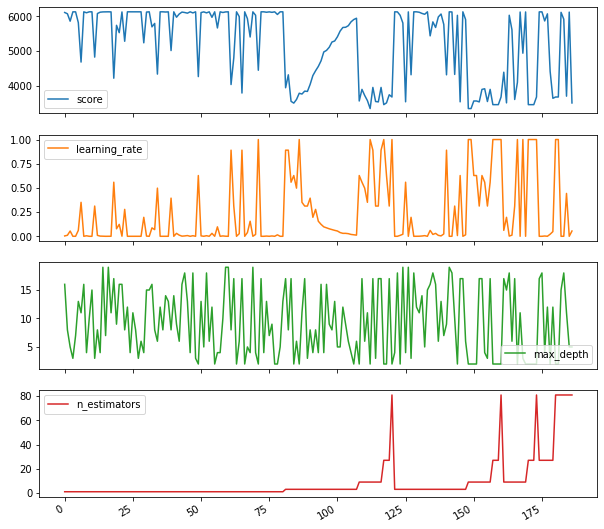

In [44]:
hb_results_df=pd.DataFrame(np.transpose([-hb.cv_results_['mean_test_score'],
                                         hb.cv_results_['param_learning_rate'].data,
                                         hb.cv_results_['param_max_depth'].data,
                                         hb.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
hb_results_df.plot(subplots=True,figsize=(10, 10))

## 4. Bayesian optimization

Random 또는 Grid Search와 달리 베이지안 접근 방식은 목표 함수의 점수 확률에 하이퍼 파라미터를 매핑하는 확률 모델을 형성하는데 사용하는 과거 평가 결과를 추적합니다.

![](https://github.com/hyeonsangjeon/Hyperparameters-Optimization/blob/master/pic/BayesianOpt.gif?raw=true)

<img src="https://github.com/hyeonsangjeon/Hyperparameters-Optimization/blob/master/pic/bayesopt2.png?raw=true" style="height:320px;"  />





*P(Score | Hyperparameters)*

논문에서 이 모델은 목적 함수에 대한 "surrogate"라고하며 p (y | x)로 표시됩니다. surrogate 함수는 목적 함수보다 최적화하기 훨씬 쉬우 며 베이지안 방법은 대리 함수에서 가장 잘 수행되는 하이퍼 파라미터를 선택하여 실제 목적 함수를 평가할 다음 하이퍼 파라미터 세트를 찾는 방식으로 작동합니다. 

pseudo code로 정리하면:
> 1. 목적 함수의 대리 확률 모델 구축
2. surrogate에서 가장 잘 수행되는 하이퍼 파라미터를 찾습니다.
3. 이러한 하이퍼 파라미터를 실제 목적 함수에 적용
4. 새 결과를 통합하는 대리 모델 업데이트
5. 최대 반복 또는 시간에 도달 할 때까지 2-4 단계를 반복합니다.

더 깊이있는 베이지안 최적화에 대한 훌륭한 커널은 여기 참조: https://www.kaggle.com/artgor/bayesian-optimization-for-robots

- Surrogate Model :
현재까지 조사된 입력값-함숫값 점들 ${(𝑥_1,f(𝑥_1)), ..., (𝑥_𝑡,f(𝑥_𝑡))}$ 를 바탕으로, 미지의 목적 함수의 형태에 대한 확률적인 추정을 수행하는 모델 

- Acquisition Function:
 목적 함수에 대한 현재까지의 확률적 추정 결과를 바탕으로, ‘최적 입력값 ${𝑥^∗}$를 찾는 데 있어 가장 유용할 만한’ 다음 입력값 후보 ${𝑥_(𝑡+1)}$을 추천해 주는 함수
   Expected Improvement(EI) 함수를 사용한다.  
   
   
   
수행속도:
> - Accuinsight+ modeler (18 CPU- 162core) Wall time:  2min 24s
> - AMD 2700x (1 CPU - 8Core) Wall time: 1min 36s

상대적으로 로컬테스트의 수행 속도가 빠른것을 볼수있었다.

In [57]:
#! pip install scikit-optimize
#https://towardsdatascience.com/hyperparameter-optimization-with-scikit-learn-scikit-opt-and-keras-f13367f3e796
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


In [47]:
%%time

search_space = {"bootstrap": Categorical([True, False]), # values for boostrap can be either True or False
        "max_depth": Integer(2, 20), # values of max_depth are integers from 2 to 20
        "max_features": Categorical(['auto', 'sqrt','log2']), 
        "min_samples_leaf": Integer(2, 20),
        "min_samples_split": Integer(2, 10),
        'learning_rate': np.logspace(-5, 0, 100),
        "n_estimators": Integer(100,2000 )
    }


                 

def on_step(optim_result):
    """
    Callback meant to view scores after
    each iteration while performing Bayesian
    Optimization in Skopt"""
    score = bayes_search.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True
    
bayes_search = BayesSearchCV(model, search_space, n_iter=n_iter, # specify how many iterations
                                    scoring='neg_mean_squared_error', n_jobs=-1, cv=5)
bayes_search.fit(train_data, train_targets, callback=on_step) # callback=on_step will print score after each iteration

bayes_test_score=mean_squared_error(test_targets, bayes_search.predict(test_data))

print('===========================')
print("Best MSE = {:.3f} , when params {}".format(-bayes_search.best_score_, bayes_search.best_params_))
print('===========================')

best score: -4332.380989720823
best score: -4332.380989720823
best score: -4291.348658839158
best score: -3808.767072314307
best score: -3808.767072314307
best score: -3758.0328052409527
best score: -3758.0328052409527
best score: -3758.0328052409527
best score: -3758.0328052409527
best score: -3758.0328052409527
best score: -3469.537248802528
best score: -3469.537248802528
best score: -3469.110899989733
best score: -3468.7517824410297
best score: -3468.7517824410297
best score: -3468.7517824410297
best score: -3465.7582899264726
best score: -3465.7582899264726
best score: -3465.6621808985897
best score: -3465.6621808985897
best score: -3465.4707345162947
best score: -3465.4707345162947
best score: -3465.4707345162947
best score: -3465.4707345162947
best score: -3465.4707345162947
best score: -3465.4707345162947
best score: -3465.4707345162947
best score: -3463.137818898732
best score: -3463.137818898732
best score: -3463.137818898732
best score: -3463.137818898732
best score: -3463.13

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

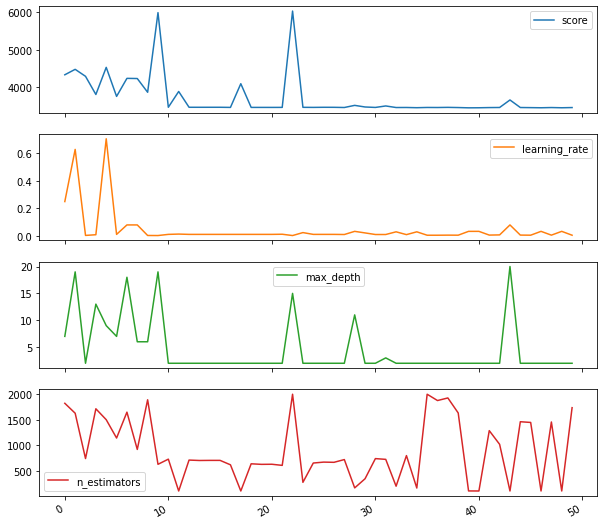

In [48]:
bayes_results_df=pd.DataFrame(np.transpose([
                                         -np.array(bayes_search.cv_results_['mean_test_score']),
                                         np.array(bayes_search.cv_results_['param_learning_rate']).data,
                                         np.array(bayes_search.cv_results_['param_max_depth']).data,
                                         np.array(bayes_search.cv_results_['param_n_estimators']).data
                                        ]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])



bayes_results_df.plot(subplots=True,figsize=(10, 10))

## 5.Hyperopt
- 이 알고리즘을 다루기 위해 hyperopt [https://github.com/hyperopt/hyperopt] 라이브러리를 사용합니다.
- 현재, 하이퍼 파라미터 최적화를위한 최신 라이브러리중 하나입니다.

In [58]:
#!pip install hyperopt

우선 hyperopt에서 몇 가지 유용한 함수를 소개합니다. 
- fmin :   최소화 메인 목적 함수
- tpe and anneal : optimization 접근방식
- hp : 다양한 변수들의 분포 포함
- Trials : logging에 사용


In [50]:
from hyperopt import fmin, tpe, hp, anneal, Trials

hyperop.fmin의 인터페이스는 Grid 또는 Randomized search와 다릅니다. 
먼저, 최소화 할 함수를 정의합니다. 
-  아래는 'learning_rate', 'max_depth', 'n_estimators'와 같은 다양한 매개 변수를 최소화하는 gb_mse_cv () 함수가 있습니다.

In [51]:
def gb_mse_cv(params, random_state=random_state, cv=kf, X=train_data, y=train_targets):
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'learning_rate': params['learning_rate']}
    
    # we use this params to create a new LGBM Regressor
    model = LGBMRegressor(random_state=random_state, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1).mean()

    return score

## 5.1 Tree-structured Parzen Estimator(TPE)

### Research Paper [TPE](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)


<img src="https://github.com/hyeonsangjeon/Hyperparameters-Optimization/blob/master/pic/TPE.gif?raw=true" />

TPE는 Hyperopt의 기본 알고리즘입니다. 최적화를 위해 베이지안 접근 방식을 사용합니다. 모든 단계에서 함수의 확률 모델을 구축하고 다음 단계에서 가장 유망한 매개 변수를 선택하려고합니다. 일반적으로 이러한 유형의 알고리즘은 다음과 같이 작동합니다.
> - 1.임의의 initial point 생성 ${x^*}$
> - 2.${F(x^*)}$ 계산
> - 3.trials 로깅 이력을 사용해서, 조건부 확률모델  $P(F | x)$를 생성
> - 4.$ P (F | x) $에 따라 $ {F (x_i)} $가 더 나아질 가능성이 가장 높은 $ {x_i} $를 선택합니다.
> - 5.$ {F (x_i)} $의 real values를 계산합니다.
> - 6.중지 기준 중 하나가 충족 될 때까지 3-5 단계를 반복합니다 (예 : i> max_eval).

예를 들어 특정 TPE 알고리즘에 대한 자세한 정보는 아래 링크 참조. (이 링크 내용은 상세버전으로, 튜토리얼의 범위를 벗어납니다.)

[https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f] 

- fmin의 사용은 매우 간단합니다. 매개 변수의 가능한 공간을 정의하고 함수를 호출하기 만하면됩니다.

수행속도:
> - Accuinsight+ modeler (18 CPU- 162core) Wall time:  7.3s
> - AMD 2700x (1 CPU - 8Core) Wall time: 7.98s

In [53]:
%%time

# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 20, 1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0)
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
         )

# computing the score on the test set
model = LGBMRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),
                      max_depth=int(best['max_depth']),learning_rate=best['learning_rate'])
model.fit(train_data,train_targets)
tpe_test_score=mean_squared_error(test_targets, model.predict(test_data))

print("Best MSE {:.3f} params {}".format( gb_mse_cv(best), best))

100%|██████████| 50/50 [00:07<00:00,  7.02trial/s, best loss: 3186.7910608402444]
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Best MSE 3186.791 params {'learning_rate': 0.026975706032324936, 'max_depth': 20.0, 'n_estimators': 168.0}
CPU times: user 2.75 s, sys: 41.8 ms, total: 2.79 s
Wall time: 7.3 s


Best MSE 3186로 RandomizedSearch에 비해 시간은 걸리지만, 좀 더 나은 솔루션을 찾았습니다.

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

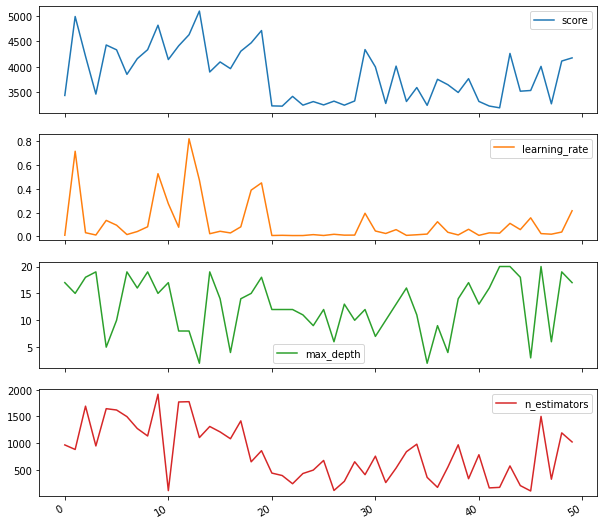

In [54]:
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
tpe_results_df.plot(subplots=True,figsize=(10, 10))

## Results

모든 접근 방식에 대해 iterations 수에 따른 best_cumulative_score를 시각화 해봅니다.

Text(0, 0.5, 'best_cumulative_score')

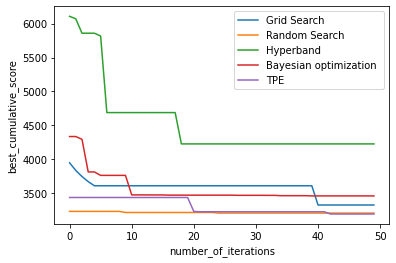

In [55]:
scores_df=pd.DataFrame(index=range(n_iter))
scores_df['Grid Search']=gs_results_df['score'].cummin()
scores_df['Random Search']=rs_results_df['score'].cummin()
scores_df['Hyperband']=hb_results_df['score'].cummin()
scores_df['Bayesian optimization ']=bayes_results_df['score'].cummin()
scores_df['TPE']=tpe_results_df['score'].cummin()


ax = scores_df.plot()

ax.set_xlabel("number_of_iterations")
ax.set_ylabel("best_cumulative_score")

- Random Search는 단순하면서, 시간의 비용에 따른 스코어가 높은 것을 알 수 있었습니다.
- TPE 알고리즘은 실제로 이후 단계에서도 시간이 지남에 따라 검색 결과를 지속적으로 개선하는 반면, Random search는 처음에 상당히 좋은 솔루션을 무작위로 찾은 다음 결과를 약간만 개선했습니다. 
- TPE와 RandomizedSearch 결과의 현재 차이는 매우 작지만, 더 다양한 범위의 하이퍼 파라미터를 사용하는 일부 실제 애플리케이션에서 hyperopt는 상당한 시간 대비 점수 향상을 제공 할 수 있으리라 봅니다. 

- 참고 : 실제 생활에서는 비교를 위해 여러 번 반복하지 않고 시간을 사용하는 것이 더 정확하지만 장난감 예제에서는 tpe 및 어닐링의 추가 계산에 소요되는 시간의 비율이 cross_val_score 계산 시간에 비해 높으므로 반복 횟수와 관련하여 하이퍼 옵트 및 플롯 점수의 계산 속도에 대해 오해하지 않기로 결정했습니다.

### 실제 Evaluate 테스트 데이터를 이용해 결과를  비교하고 교차 검증 결과와 inline 확인하겠습니다.

In [56]:
print('Test MSE scored:')
print("Grid Search : {:.3f}".format(gs_test_score))
print("Random Search :  {:.3f}".format(rs_test_score))
print("Hyperband : {:.3f}".format(hb_test_score))
print("Bayesian optimization : {:.3f}".format(bayes_test_score))
print("TPE : {:.3f}".format(tpe_test_score))



Test MSE scored:
Grid Search : 3045.329
Random Search :  2877.117
Hyperband : 3056.535
Bayesian optimization : 2748.486
TPE : 2942.574


Bayesian optimization과 Random Search알고리즘의 TEST데이터 MSE 점수가 가장 낮은것으로 나타났습니다. (실험용 Toy dataset으로 실행에 따라 결과임을 참고)

- Accuinsight+의 modeler AutoDL에 적용한 다양한 하이퍼 파라미터 최적화 접근 방식에 대해 알아봤습니다.
- 최신 hyperopt의 TPE알고리즘의 사용방법을 알 수 있었습니다. 
- 실제 모델링 환경에서는, 실제로 어떤 접근 방식이 가장 좋은지 미리 알 수 없으며, 때로는 간단한 RandomizedSearch가 좋은 선택이 될 수 있으므로 항상 알아두면 유용합니다. 
- 이 튜토리얼이 향후 ML, DL 프로젝트에서 많은 시간을 절약하기를 바랍니다.